In [23]:
import numpy as np
import pandas as pd
import cv2
import pytesseract
import torch
from torchvision import transforms
from PIL import Image 
import matplotlib.pyplot as plt

## Loading the image and using pytesseract

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\msi1\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

test = cv2.imread(r'C:\Users\msi1\Videos\extra\1d94be5d07b542579ea5fdb59602b71e.jpg')

text = pytesseract.image_to_string(test)

In [3]:
cv2.imshow('image', test)
cv2.waitKey(0)

-1

In [4]:
print(text)

BLUNDSTONE 163
PU/TPU-ELASTIC SIDED-V CUT-CSA




## Loading the model and using it on an image 

In [13]:
trained_model = torch.load(r'C:\Users\msi1\Videos\Computer_Vision_Solution\Autonomous_Shoe_Spotter\Models_and_notebooks\yolov8_trained_model.pt')
print(type(trained_model))

<class 'dict'>


In [14]:
print(trained_model.keys())

dict_keys(['date', 'version', 'license', 'docs', 'epoch', 'best_fitness', 'model', 'ema', 'updates', 'optimizer', 'train_args'])


In [15]:
model = trained_model.get('model')
model.eval()

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

        xmin   ymin    xmax    ymax  confidence      class_id  extra_feature
6274  290.00  631.0  57.000   18.50    0.579102  0.000000e+00   5.960464e-08
6275  291.00  631.0  58.500   18.50    0.690918  0.000000e+00   0.000000e+00
6276  291.00  631.0  57.750   18.50    0.732910  0.000000e+00   5.960464e-08
6277  290.75  631.0  57.000   18.50    0.743652  5.960464e-08   1.192093e-07
6354  289.75  631.0  55.500   18.50    0.537598  2.384186e-07   1.490116e-06
6355  291.25  631.0  58.000   18.50    0.694336  1.788139e-07   1.013279e-06
6356  291.00  631.0  58.250   18.50    0.743164  4.768372e-07   2.622604e-06
6357  291.00  631.0  57.000   18.00    0.728516  1.132488e-06   4.470348e-06
7328  136.00  384.0  83.875  103.25    0.517090  2.384186e-07   2.741814e-06
7977  290.50  630.5  57.750   19.00    0.542969  3.755093e-06   4.792213e-05
7978  290.50  631.0  57.250   18.50    0.686523  2.145767e-06   3.790855e-05
7979  290.25  631.0  57.500   18.50    0.592285  1.490116e-06   9.459257e-05

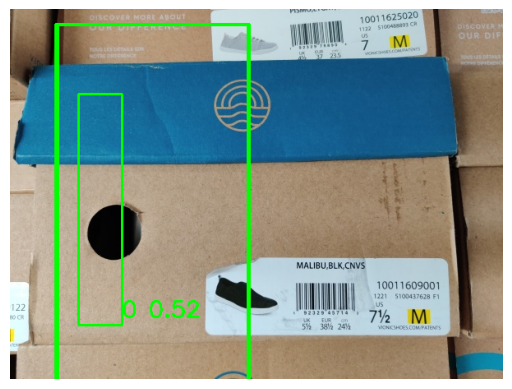

In [30]:
image = cv2.imread(r'C:\Users\msi1\Videos\maybe_test_data\Vionic\IMG_20240227_175412.jpg')
# Convert the image from BGR (OpenCV format) to RGB (YOLOv8 expects RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define a transformation to convert image to tensor
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy array to PIL image
    transforms.Resize((640, 640)),  # Resize to the expected input size (adjust as needed)
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (if required)
])

# Apply the transformation
image_tensor = transform(image_rgb)

# Add a batch dimension (1, C, H, W)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.half()  # Convert to half precision

# Ensure model is in evaluation mode
model.eval()

# Perform object detection
with torch.no_grad():
    results = model(image_tensor)

# Assuming results[0] contains the detection results
detections = results[0]

# Extract the detections
# Flatten the detections except for the batch dimension
detections = detections[0].T

# Convert detections to a pandas DataFrame (example format)
columns = ['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class_id', 'extra_feature']
results_df = pd.DataFrame(detections.numpy(), columns=columns)

# Filter out detections with low confidence if needed
results_df = results_df[results_df['confidence'] > 0.5]  # Confidence threshold

# Print the detected objects
print(results_df)

# Draw the bounding boxes on the image
for index, row in results_df.iterrows():
    x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    confidence = row['confidence']
    class_id = int(row['class_id'])
    
    # Assuming you have a mapping of class_id to class names
    class_label = str(class_id)  # Replace with actual class name if available
    
    # Draw rectangle around the object
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Put the label near the object
    cv2.putText(image, f'{class_label} {confidence:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Convert the image back to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with detections
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()